In [1]:
import numpy as np
import random
import sys
import re
import sklearn
from sklearn.ensemble import RandomForestClassifier
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import os.path as osp

import SupContrast
from SupContrast.util import TwoCropTransform, AverageMeter
from SupContrast.util import adjust_learning_rate, warmup_learning_rate
from SupContrast.util import set_optimizer, save_model
from SupContrast.networks.resnet_big import SupConResNet
from PIL import Image
import torch
from torch.nn import BatchNorm1d
from torch.utils.data import Dataset
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, ToPILImage
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU
import torch.nn
import torch.nn as nn
import torch.backends.cudnn as cudnn
import sklearn
dim=64
target=0

from functools import partial

print(torch.__version__, torch.version.cuda)

random.seed(4)
torch.manual_seed(4)
np.random.seed(4)

/home/davidb/miniconda3/envs/pyg/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.13.1 11.7


In [3]:
train_df=pd.read_csv("bbbc22/b22_dataset.csv",delimiter=";")
train_df_nonans=pd.read_csv("bbbc22/b22_dataset_mesh_nonans.csv",delimiter=";")

/tmp/ipykernel_3678316/2729755841.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df=pd.read_csv("bbbc22/b22_dataset.csv",delimiter=";")


## Create the pytorch dataset

In [4]:
print(len(train_df),len(train_df_nonans))
resize_images=False
read_path='/media/davidb/ssd/5CJ_224x224/5Cimg_224x224cv_'
name_pos=list(train_df.columns).index("Image_Metadata_SOURCE_COMPOUND_NAME")
mock_pos=list(train_df.columns).index("Bioactive")
inputX_key="MeSHes"
inputX_pos_sing=list(train_df.columns).index("MeSHCategorical_codes")
conc_pos=list(train_df.columns).index("Image_Metadata_CPD_MMOL_CONC")
res1,res2=224,224
class merged_img_ds(Dataset):
    def __init__(self, df=train_df,transform=None,img_transform=None,alt_view=None): 
        self.input = df
        self.transform = transform
        self.img_transform = img_transform
    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        name = self.input.iloc[idx,name_pos] 
        image_index=str(self.input.index[idx])
        image=Image.open(read_path+str(image_index)+'.png').convert('RGB')   
        neigh=list(self.input[self.input.Image_Metadata_SOURCE_COMPOUND_NAME==name].index)#replicates
        name_ilocs=[]
        for locs in neigh:
            name_ilocs.append(self.input.index.get_loc(locs))#gets ilocs
        name_ilocs.remove(idx) 
        neigh_idx=random.choice(name_ilocs)
        neigh_idx_image=str(self.input.index[neigh_idx])
        neigh_img=Image.open(read_path+str(neigh_idx_image)+'.png').convert('RGB')  
        if resize_images:
            image=image.resize((res1, res2),resample=Image.NEAREST)  
        conc = self.input.iloc[idx,conc_pos]
        conc=np.array(float(conc))     
        inputX_values=  self.input.iloc[idx,inputX_pos_sing] 
        inputX_values=np.array(inputX_values)
        assay_role= self.input.iloc[idx,mock_pos]
        assay_role=np.array(assay_role)   
        if self.img_transform=="neighbor":
            sample = {'image': image, 'Bioactive': assay_role,"Conc":conc, inputX_key:inputX_values, "Name":name,"Aug":neigh_img}
            sample = self.transform(sample,image_transform="neighbor")
        return sample


69084 30168


In [5]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample,image_transform=False):
        if image_transform:
            image, bioactive, Conc,inputX_values, name,aug = sample['image'], sample['Bioactive'],sample['Conc'],sample[inputX_key], sample['Name'],sample["Aug"]
        else:
            image, bioactive, Conc,inputX_values, name = sample['image'], sample['Bioactive'],sample['Conc'],sample[inputX_key], sample['Name']

        image=np.asarray(image)
        image = image.transpose(2, 0, 1)
        image=torch.from_numpy(image.copy())
        if image_transform=="neighbor":
            aug=np.asarray(aug)
            aug = aug.transpose(2, 0, 1)
            aug=torch.from_numpy(aug.copy())
        if image_transform:
            return {'image': image,'Bioactive': torch.from_numpy(bioactive),'Conc': torch.from_numpy(Conc),inputX_key:torch.from_numpy(inputX_values),"Name":name,"Aug":aug}
        else:
            return {'image': image,'Bioactive': torch.from_numpy(bioactive),'Conc': torch.from_numpy(Conc),inputX_key:torch.from_numpy(inputX_values),"Name":name}
train_dataset=merged_img_ds(df=train_df,transform=ToTensor(),img_transform="neighbor")
train_dataset_nonans=merged_img_ds(df=train_df_nonans,transform=ToTensor(),img_transform="neighbor")
len(train_dataset),len(train_dataset_nonans)

(69084, 30168)

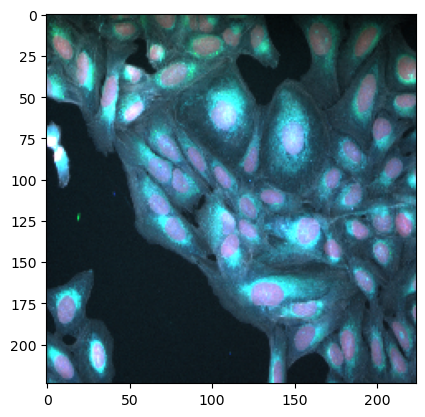

In [6]:
plt.imshow(train_dataset[55200]["image"].numpy().transpose())

In [7]:
bs=20
bs2=20
workers=1
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True,
                                           pin_memory=True, batch_size=bs2, drop_last=True, num_workers=workers)
train_loader_nonans = torch.utils.data.DataLoader(train_dataset_nonans, shuffle=True, pin_memory=True,
                                                  batch_size=bs,
                                                  drop_last=True, num_workers=workers)

#### SupConLoss

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07,device=device):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [9]:
def set_model(ddp_gpu=True,gpu=True):
        model = SupConResNet(name='resnet50', feat_dim=224)
        criterion = SupConLoss(temperature=0.07)
        if ddp_gpu:
            model.encoder = torch.nn.DataParallel(model.encoder,device_ids=list(range(0,8)))
        if gpu:
            model = model.cuda(device=device)
            criterion = criterion.cuda(device=device)
        cudnn.benchmark = True

        return model, criterion
model, criterion = set_model(ddp_gpu=True,gpu=True)
bsz=bs
bsz2=bs2
print(bsz,bsz2)

20 20


In [10]:
save=True
PATHx_save="models/b22/model_supbs"+str(bs)+"unsup"+str(bs2)+"_bbbc22_5CJ_semisupcon.pt"

In [11]:
PATHx_save

'models/b22/model_supbs20unsup20_bbbc22_5CJ_semisupcon.pt'

In [12]:
outfile="embeddings/emb"+PATHx_save.split("/")[-1][5:-3]+".csv"
logfile="log"+PATHx_save.split("/")[-1][5:-3]
outfile,logfile

('embeddings/emb_supbs20unsup20_bbbc22_5CJ_semisupcon.csv',
 'log_supbs20unsup20_bbbc22_5CJ_semisupcon')

In [20]:
with open(outfile, "w") as g:
    g.write("")
def trainNtest(outfile=outfile):#train on annotated subset and save embeddings for downstream classification
    count=0
    model.train()
    seperator=";"
    y_available=True
    loss_all=0
    with open(outfile, "w+") as g:
        g.write("")
    for data in train_loader_nonans:
      count+=1
      y_output=[]
      ylabel=[]
      entropy=[]
      latentnames=[]
      img_pos=[]
      error = 0
      data = [im for im in data.values()]
      images=data[0].to(device).float()
      aug=data[5].to(device).float()
      labels=data[3].cuda(device=device, non_blocking=True) 
      images = torch.cat([images, aug], dim=0)
      optimizer.zero_grad()
      features = model(images)
      f1, f2 = torch.split(features, [bsz, bsz], dim=0)
      features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
      loss = criterion(features, labels)
      loss.backward()
      loss_all += loss.item()  
      optimizer.step()
      if y_available:
              y_output.append(features.cpu().detach().numpy())
              ylabel.append(labels.cpu().detach().numpy())
              entropy.append(loss.cpu().detach().numpy())
              img_pos.append(data[2])
      with open(outfile, "a+") as g:
          for no,point in enumerate(data[4]):
              youtput_str=[str(value) for value in y_output[0][no][0]]
              g.writelines(point+seperator+str(ylabel[0][no])+seperator+str(entropy[0]))
              g.write(";")
              g.write(";".join(youtput_str))
              g.write("\n")
    return loss_all/len(train_df_nonans)

def dsRF(outfile=outfile):
    dft=pd.read_csv(outfile,header=None,index_col=0,delimiter=";")
    dft["Molecules"]=dft.index
    groups = [df for _, df in dft.groupby('Molecules')]
    random.shuffle(groups)
    test_dfX_2=pd.concat(groups).reset_index(drop=True)
    unique=len(set(test_dfX_2.Molecules))
    tr_part2=round(unique*0.8)*36
    skX2,skY2=test_dfX_2.iloc[:tr_part2,2:-1],test_dfX_2[1][:tr_part2]
    skX_test2,skY_test2=test_dfX_2.iloc[tr_part2:,2:-1],test_dfX_2[1][tr_part2:]
    rf = RandomForestClassifier(n_estimators=1000, random_state=0,n_jobs=20)
    rf.fit(skX2, skY2)
    score=rf.score(skX_test2,skY_test2)
    print(score, "Accuracy")
    
    return score

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=10**-2.5)

In [ ]:
def train(epoch):
    model.train()
    loss_all = 0
    for data in train_loader_nonans:
        data = [im for im in data.values()]
        images=data[0].cuda(device=device,non_blocking=True).float()
        aug=data[5].cuda(device=device,non_blocking=True).float()
        labels=data[3].cuda(device=device,non_blocking=True)#.int()
        images = torch.cat([images, aug], dim=0)
        optimizer.zero_grad()
        features = model(images)
        f1, f2 = torch.split(features, [bsz, bsz], dim=0)
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
        loss = criterion(features,labels)
        loss.backward()
        loss_all += loss.item() 
        optimizer.step()
    return loss_all / (len(train_df_nonans))#
def unsup_train(epoch):
    model.train()
    loss_all = 0
    for data in train_loader:
        data = [im for im in data.values()]
        images=data[0].cuda(device=device,non_blocking=True).float()
        aug=data[5].cuda(device=device,non_blocking=True).float()
        images = torch.cat([images, aug], dim=0)
        optimizer.zero_grad()
        features = model(images)
        f1, f2 = torch.split(features, [bsz2, bsz2], dim=0)
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
        loss = criterion(features)
        loss.backward()
        loss_all += loss.item() 
        optimizer.step()
    return loss_all / (len(train_df))



ep=300
debug=False
if debug:
  ep=2
for epoch in range(1,ep):
    loss=0
    start=time.time()    
    scoreRF=0
    if epoch % 2 == 0 or epoch==1:
        loss = trainNtest()
        sup_loss=str(loss)
        print("Supervised loss", loss)
        print("Calculate Accuracy:")
        scoreRF=dsRF()
        print(abs(time.time()-start))
    else:
        loss = train(epoch)
        sup_loss=str(loss)
        print("Supervised loss", loss)
        print(abs(time.time()-start))
    loss += unsup_train(epoch)
    if save:
      torch.save(model.state_dict(), PATHx_save)
    end=time.time()
    diff_time=abs(start-end)
    print(diff_time)
    print('Epoch: {:03d}, Loss: {:.7f}'.format(epoch,  loss))
    with open(logfile,"a+") as g:
            g.writelines("Supervised loss "+ str(sup_loss)+"\n")
            g.writelines(str(diff_time)+"\n")
            g.writelines('Epoch: {:03d}, Loss: {:.7f}'.format(epoch, loss)+"\n")
            g.writelines(str(scoreRF)+"accuracy \n")

Supervised loss 0.18299984827625818
Calculate Accuracy:
0.01390728476821192 Accuracy
1570.6924965381622
4709.351799726486
Epoch: 001, Loss: 0.3505279
Supervised loss 0.1826240097581787
Calculate Accuracy:
0.01423841059602649 Accuracy
1519.8343687057495
4658.749383211136
Epoch: 002, Loss: 0.3432098
Supervised loss 0.1827153546191817
1370.264487504959
4507.715377569199
Epoch: 003, Loss: 0.3417389
Supervised loss 0.1825698763882883
Calculate Accuracy:
0.01109271523178808 Accuracy
1509.8152837753296
4646.466359376907
Epoch: 004, Loss: 0.3406312
Supervised loss 0.1826887823121676
1369.622148990631


In [ ]:
PATHy=""
pretrain=True
if pretrain:
  #model = NetIIv_ac_glo()
  model.load_state_dict(torch.load(PATHy,map_location=torch.device('cuda') ))
  #model.load_state_dict(torch.load(PATHy ))
model.to(device);

In [ ]:
#use trained model to calculate embeddings for the images to outfile.csv
def testwrite(loader,outfile=outfile):#calculate embeddings, without training
    count=0
    model.eval()
    seperator=";"
    y_available=True
    loss_all=0
    with open(outfile, "w+") as g:
        g.write("")
    for data in loader:
      count+=1
      y_output=[]
      ylabel=[]
      entropy=[]
      latentnames=[]
      img_pos=[]
      error = 0
      data = [im for im in data.values()]
      images=data[0].to(device).float()
      aug=data[5].to(device).float()
      labels=data[3].to(device)
      images = torch.cat([images, aug], dim=0)
      with torch.no_grad():
          features = model(images)
          f1, f2 = torch.split(features, [bs, bs], dim=0)
          features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
          loss = criterion(features)  
      if y_available:
              y_output.append(features.cpu().detach().numpy())
              ylabel.append(labels.cpu().detach().numpy())
              entropy.append(loss.cpu().detach().numpy())
              img_pos.append(data[2])
      with open(outfile, "a+") as g:
          for no,point in enumerate(data[4]):
              youtput_str=[str(value) for value in y_output[0][no][0]]
              g.writelines(point+seperator+str(ylabel[0][no])+seperator+str(entropy[0]))
              g.write(";")
              g.write(";".join(youtput_str))
              g.write("\n")
    return loss_all/(len(loader)*bs)